<a href="https://colab.research.google.com/github/SquidsofDoom/QCES/blob/main/Project1_numerical_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1: Heat transport

In this project we will discretize and timestep two systems that describe heat transport. In the first part we will timestep a box model for the Earth's surface temperature with heat buffering provided by the deep ocean. In the second part, we will timestep the one-dimensional diffusion equation which can be used to describe heat moving through a medium (e.g. the ground or still air and water).

Through this project, we will learn how to efficiently timestep ordinary and partial differential equations and examine errors introduced by the numerical discretization. We will also have the chance to explore the timescales and physical processes involved in heat transport in the climate system.

## 1. Climate box model

In this part of the project we will timestep the following box model.

$$ C_s \partial_t T = F(t) - \gamma(T-\theta) $$

$$ C_d \partial_t \theta = \gamma (T-\theta) $$

Here, $T(t)$ represents the global mean surface temperature as a function of time and $\theta(t)$ is the temperature of the deep ocean, both expressed as the difference between the temperature and a pre-industrial equilibrium in units of $^\circ K$. The net surface heat flux, $F(t)$, drives departures from the pre-industrial temperatures. The heat flux between the surface and deep ocean is assumed to be proportional to the difference between the surface and deep ocean temperatures. The constants are the heat capacity of the surface of the Earth, $C_s$, the heat capacity of the deep ocean, $C_d$, and the heat flux coefficient, $\gamma$, all given in units of $W/^\circ K/m^2$. Note that $C_s$ and $C_d$ (as defined in Nicklas et al. 2025) are heat capacities per year; i.e. $1/C_s$ tells us how much the surface temperature would increase if a flux of 1 $W/m^2$ were applied for one year.

This model is inspired by a more complicated version of a two box climate model in the paper referenced below. (Interested students might consider adding some additional features from their model, but this is not required for this project).

*Nicklas, J.M., Fox-Kemper, B. and Lawrence, C., 2025. Efficient Estimation of Climate State and Its Uncertainty Using Kalman Filtering with Application to Policy Thresholds and Volcanism. Journal of Climate, 38(5), pp.1235-1270.*

Below, we start to build code to solve these equations. Execute the code cells below.  In some cases you will be asked to add code.

Student tasks are in [Section 1.1](#section1pt1), [Section 1.2](#section1pt2), and [Section 1.3](#section1pt3).

In [ ]:
# Before we start, import necessary libraries. Run this cell first.
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import time

Now, let's define values for the various constants. These values are taken from Nicklas et al., 2025.

In [ ]:
C_s = 17 # heat capacity of the Earth's surface (W/m^2/K)
C_d = 156 # heat capacity of the deep ocean (W/m^2/K)
gamma = 0.67 # heat exchange coefficient between surface and deep ocean (W/m^2/K)

Now, let's define a function for F(t), the net surface heat flux (in units of $W/m^2$) that will force our model. This function is here to represent the heat imbalance caused by antropogenic greenhouse gases in the atmosphere. When $F=0$, there is no net surface heat flux. The argument, $t$, is the time in years. We will let $t=0$ denote the start of our additional warming, and we set $F=1$ if $t<200$ years and $F=0$ if $t>200$ years. This corresponds to a very bad-case emissions scenario with an abrupt drop in emissions after 200 years.

In [ ]:
def F(t):
    return 1 if t < 200 else 0

Next, set the initial conditions. We will use arrays `T` and `theta`. `T[i]` represents the ith value in the array. We will use `T[0]` and `theta[0]` to hold the initial conditions. Subsequent values, `T[2]`, `T[3]`, etc. will be determined by timestepping the equations. We start by initializing the arrays using numpy and filling them with zeros and then set the initial values (this isn't necessary here since our values are zero anyway, but the code is here to that you can change the initial conditions easily)

In [ ]:
Nt = 500 # number of time steps (including the starting point)
T = np.zeros(Nt) # surface temperature array
theta = np.zeros(Nt) # deep ocean temperature array
T[0] = 0 # initial surface temperature anomaly (ºK)
theta[0] = 0 # initial deep ocean temperature anomaly (ºK)

Now, create an array with the time (in years) corresponding to each time index. Also, calculate the timestep, `dt`.

In [ ]:
t = np.linspace(0, 500, Nt) # time in years.  This starts at 0 and ends at 500, with Nt total points
dt = t[1] - t[0] # timestep in years

Finally, we are ready to create a for loop to timestep the equations listed at the top of the section.

### 1.1 Student task:
<a id='section1pt1'></a>
Fill in the interior of the for loop to timestep the equations from the start of Section 1 using the Explicit Euler method.

In [ ]:
for i in range(0, Nt-1):
    T[i+1] = T[i] + dt *(F(t[i])-gamma*(T[i]-theta[i]))/(C_s)
    theta[i+1] = theta[i] + dt * (gamma*(T[i]-theta[i])/(C_d))

After you are finished, run the cell below to plot the results

In [ ]:
plt.plot(t,T,'r-')
plt.plot(t,theta,'b-')
plt.legend(['Surface temperature','Deep ocean temperature'])
plt.xlabel('Time (years)')
plt.ylabel('Temperature anomaly (ºK)')
plt.show()

### 1.2 Student task
<a id='section1pt2'></a>
Discuss the rates of change the temperature of the Earth's surface and the deep ocean at the start of the model run.  Can you explain the response of $T$ and $\theta$ to the forcing by defining characteristic timescales from the box model equations?

In the region where forcing is active ($t<200$), we see that the surface temperature anomaly $T$ grows much faster than the deep ocean anomaly, $\theta$. Analysis from units shows that surface anomaly time is characteristic in $t_s \sim C_s/\gamma \approxeq 25.4$ years. We see a much more sluggish response time in the deep-ocean layers, where $t_d \sim C_d/\gamma \approxeq 232.8$ years. This explains why $T$ grows exponentially (as if uncoupled) in the first half-century, until $\theta$ can 'catch up' and make any contribution via the differential equations.

It is interesting to note that $T$ and $\theta$ grow linearly at the same rate in the range $100<t<200$, a trend which holds even when $t_{cutoff}$ is increased. We can see why if we subtract the differential equations from one another:


$$\alpha(t) = \frac{C_d}{\gamma (C_d - C_s)}[1-e^{-\gamma (\frac{C_d - C_s}{C_d C_s})t}]$$


For $\alpha(t) = T(t) - \theta (t)$. For $C_d >> C_s$, we find that we can relate the rates of change by


$$\frac{dT}{dt} = \frac{d\theta}{dt} + 0.058 e^{\frac{-\gamma}{C_s}t} \approxeq \frac{d\theta}{dt}$$


Given that both functions have a similar rate of change, but are both exponentials with different typical times, they must be both interact to become linear. We interpret that the response time of $T$ is quick enough to 'adapt' itself to the value of $\theta$ to cause them to grow at the same rate.
We see this again at $t>200$. Here, the forcing is removed and the system finds equilibrium. In the time it takes for $T$ to establish equilibrium, $\theta$ has barely moved, and so $T$ drops down to 'meet' $\theta$ at its most recent value. So $T_{eq} = \theta_{eq} \approxeq \theta(t=200)$. We expect to see this dynamic wherever there is a great difference in characteristic timescales.

### 1.3 Student task
<a id='section1pt3'></a>
Modify the forcing function, `F(t)` above with 2-3 scenarios of your choice. Plot the temperature response for each scenario and briefly (2-3 sentences each) describe the temperature responses in each scenario. You will need to replicate some of the code blocks above so that you can produce a new set of plots below.

In [ ]:
ax, fig = plt.subplots(3,1, figsize = (9,15))

def F1(t):
    return 1-0.005*t if t < 200 else 0

for i in range(0, Nt-1):
    T[i+1] = T[i] + dt *(F1(t[i])-gamma*(T[i]-theta[i]))/(C_s)
    theta[i+1] = theta[i] + dt * (gamma*(T[i]-theta[i])/(C_d))
ax1 = plt.subplot(3,1,1)
ax1.plot(t,T,'r-')
ax1.plot(t,theta,'b-')
ax1.legend(['Surface temperature','Deep ocean temperature'])
ax1.set_xlabel('Time (years)')
ax1.set_ylabel('Temperature anomaly (ºK)')
ax1.set_title('Slowing Emissions Scenario')


def F2(t):
    return 1 if t < 100 else 0

for i in range(0, Nt-1):
    T[i+1] = T[i] + dt *(F2(t[i])-gamma*(T[i]-theta[i]))/(C_s)
    theta[i+1] = theta[i] + dt * (gamma*(T[i]-theta[i])/(C_d))

ax2 = plt.subplot(3,1,2)
ax2.plot(t,T,'r-')
ax2.plot(t,theta,'b-')
ax2.legend(['Surface temperature','Deep ocean temperature'])
ax2.set_xlabel('Time (years)')
ax2.set_ylabel('Temperature anomaly (ºK)')
ax2.set_title('Shorter Cut-Off Time')


def F3(t):
    return 1 if t < 150 else 0 if 151<t<200 else -0.5

for i in range(0, Nt-1):
    T[i+1] = T[i] + dt *(F3(t[i])-gamma*(T[i]-theta[i]))/(C_s)
    theta[i+1] = theta[i] + dt * (gamma*(T[i]-theta[i])/(C_d))

ax3 = plt.subplot(3,1,3)
ax3.plot(t,T,'r-')
ax3.plot(t,theta,'b-')
ax3.legend(['Surface temperature','Deep ocean temperature'])
ax3.set_xlabel('Time (years)')
ax3.set_ylabel('Temperature anomaly (ºK)')
ax3.set_title('Reduction Followed by Extraction Scenario')

plt.show()



In the first case, we see that the curve has smoothed, however still holds similar mechanics to the first case in graph 1.2. The smoother peak is a result of the fact that carbon is continually being pulled out of the atmosphere, so there is not as much of an abrupt stop and drop to equilibrium. We also see that the peak anomoly value for $T$ and the final equilibrium value is lower, as less carbon has been put into the atmosphere over the same 200 year time-frame.

The second scenario, where the emissions-cuttof year has been brought back to 100 years from now, shows effectively the same dynamics over the 1st century as graph in 1.2. We see less of a linear portion in $T$ and $\theta$, as the cutoff point is reached earlier. Again, we have a lower equilibrium value than both the first of these scenarios and 1.2, and equilibrium is established around $\theta(t=100)$.

The final scenario represents a sharp cut-off of emissions, followed by some extraction of $CO_2$ from the atmosphere. This corresponds to a negative forcing term, and we see that once this term kicks in there is a negative trend in both temperature anomalies. The downward trend begins while the system was establishing equilibrium, and both begin to demonstrate their linear behaviour right away. This may be because $\theta$ and $T$ are at similar orders at this time, so they are strongly coupled by the differential equations (compare the first 50 years of graph 1.2, where they grow almost independently).  

## 2. Diffusion equation

In this part of the project we will solve the 1-D diffusion equation:

$$ \partial_t c = \kappa \partial_x^2 c $$

We will use second order finite differences to approximate the $x$-derivatives, and we will implement and compare two timestepping methods.

Student tasks are in [Section 2.1](#section2pt1), [Section 2.2](#section2pt2), and [Section 2.3](#section2pt3).

First, let's discretize the second order derivative using finite differences. The function below builds a coefficient matrix, $M$, so that $Mc$ is a discretized version of $\partial^2_x c$, where in our discretized version $c$ is a column vector.

In [ ]:
    def construct_M(x):
    # Build a coefficient matrix, such that M*c is the discrete version of d^2/dx^2(c)
        dx = x[1] - x[0]  # Infer the uniform grid spacing
        M = (np.diag(np.ones(Nx-1), -1) - 2*np.diag(np.ones(Nx), 0) + np.diag(np.ones(Nx-1), 1)) / dx**2
        M = sp.csr_matrix(M) # Turn M into a sparse matrix to save memory and improve speed
        return M

Now, define two functions to timestep the diffusion equation. The code below timesteps the diffusion equation using the expicit Euler method. The function takes in a vector of discrete positions, `x`, discrete times, `t`, and the diffusivity, `kappa`. The vectors `x` and `t` dictate the discretization of the problem in space and time, and the grid spacing must be constant in space and time. The boundary conditions are $\partial_x c=0$ at the starting and ending points in `x`.

In [ ]:
def EE(x, t, kappa):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods

    start_time = time.time()  # Start a timer

    # Infer the timestep from the time array
    dt = t[1] - t[0]

    M = construct_M(x)  # Construct the coefficient matrix for the second derivative

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt):  # loop over the number of timesteps
      c[:,k] = c[:,k-1] + dt * kappa * M @ c[:,k-1]
      # Enforce the boundary conditions (no flux)
      c[0, k] = c[1, k]
      c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    #print(f"Explicit Euler method took {end_time - start_time:.2f} seconds")

    return c

Similarly, the function below timesteps the diffusion equation with the Crank-Nicolson method

In [ ]:
def CN(x, t, kappa):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods
    start_time = time.time()  # Start a timer

    # Infer the timestep from the time array
    dt = t[1] - t[0]

    M = construct_M(x)  # Construct the coefficient matrix for the second derivative

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    A = sp.eye(Nx) - 0.5 * dt * kappa * M  # This matrix appears on the LHS in the C-N scheme
    A_inv = spla.inv(A) # Calculate the inverse of A (this only needs to be done once)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt): # loop over the number of timesteps
        c[:, k] = A_inv @ (c[:, k-1] + 0.5 * dt * kappa * (M @ c[:, k-1]))
        # Enforce the boundary conditions
        c[0, k] = c[1, k]
        c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    #print(f"Crank-Nicolson method took {end_time - start_time:.2f} seconds")
    return c

Next, create a function to set the initial conditions. The exact solution to the unbounded diffusion equation with a delta function initial condition is:

$$\left(\frac{1}{4\pi\kappa t}\right)^{1/2}e^{-x^2/(4\kappa t)}$$

The function below sets the initial condition by evaluating the exact solution at a given time. Note that it is important that we don't evaluate the exact solution at `t_ic=0` since this will return a delta function which will be undefined on our finite grid. The value of `t_ic` is set within the `EE` and `CN` functions.

In [ ]:
# Function to set the initial condition from the exact solution at time t_start
def set_ics(x, kappa, t_ic):
    c_ic = (4*np.pi*kappa*t_ic)**(-0.5)*np.exp(-x**2 / (4*kappa*t_ic))
    # Enforce the boundary conditions
    c_ic[0] = c_ic[1]
    c_ic[-1] = c_ic[-2]
    return c_ic


Finally, define some parameters and the x and t vectors:

In [ ]:
# Defining parameters
kappa = 0.001  # diffusivity

# Timestepping parameters
t_start = 0  # start time (note that this is not the same time used to evaluate the exact solution to set the ICs)
t_end = 10  # end time
Nt = 1000  # number of timesteps

# Size of the physical domain
x_start = -1
x_end = 1
Nx = 100

t = np.linspace(t_start, t_end, Nt)  # Create a vector of times
x = np.linspace(x_start, x_end, Nx)  # Create a vector for x

Run each method once:

In [ ]:
# Run the simulations
c_EE = EE(x, t, kappa) # explicit Euler
c_CN = CN(x, t, kappa) # Crank-Nicolson

and finally, plot the results side-by-side

In [ ]:
# Plot the results
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.pcolormesh(x, t, c_EE.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Explicit Euler')

plt.subplot(1, 2, 2)
plt.pcolormesh(x, t, c_CN.T, shading='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Crank-Nicolson')

plt.tight_layout()
plt.show()

## 2. Student investigation

### 2.1 Stability
<a id='section2pt1'></a>
The explicit Euler and Crank-Nicolson methods have different stability properties. To explore this, try increasing the diffusivity, $\kappa$, and see how each method responds. Discuss your findings below (~2-3 sentences).

The Explicit Euler (EE) method becomes unstable sharply at $\kappa = 0.021$, while the Crank-Nicolson (CN) method stays stable for much larger values of $\kappa$ (***HOW MUCH??***). EE is expected to be more unstable, as it only considers the term before it (ie explicit), meaning it is susceptible to growing to infinity. CN does not have this property, as it it considers the value after the time step as well. Interestingly, the instability occurs at exactly the value of $\kappa = dx$. This could be because, here the diffusion is occuring at a larger rate than the grid-spacing can resolve, so there is a runaway effect.

### 2.2 Accuracy
<a id='section2pt2'></a>
Next, we will examine the accuracy of the numerical methods used above. In order to do this, it is useful to compare our numerical solutions with the exact solution to the diffusion equation. Below, write code to plot the exact solution and the numerical solution using explicit Euler and Crank-Nicolson at the final time ($t=10$). Note that you can use the exact solution to the diffusion equation in an unbounded domain in $x$ and keep in mind that the exact solution and numerical solutions will differ for later times when boundary effects are felt.

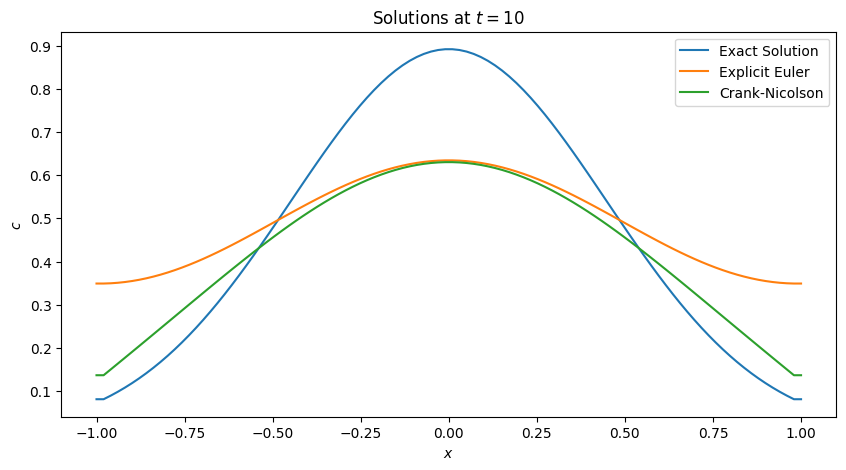

In [17]:
kappa = 0.01


c_EE = EE(x, t, kappa)
c_CN = CN(x, t, kappa)

plt.figure(figsize=(10, 5))
plt.plot(x, set_ics(x, kappa, 10), label='Exact Solution')
plt.plot(x, c_EE[:,-1], label='Explicit Euler')
plt.plot(x, c_CN[:,-1], label='Crank-Nicolson')
plt.legend()

plt.xlabel(r'$x$')
plt.ylabel(r'$c$')
plt.title(r'Solutions at $t=10$')

plt.show()

The difference between the exact solution and the numerical approximation can be quantified by various measures of error. The *local error* is the difference between the exact solution and the numerical approximation after one timestep. The *global error* is the difference between the solutions after a fixed amount of time (which includes the accumulation of multiple steps of local error). A method is first order accurate if the global error is linearly proportional to the timestep. A method is second order accurate if the global error varies quadratically with the timestep. Below, calculate and plot the global error for the Explicit Euler and Crank-Nicolson methods and use your results to infer the order of accuracy of each scheme.

PLOT GLOBAL ERROR FOR EACH SCHEME (1-2 figures) AND DISCUSS ORDER OF ACCURACY (2-3 sentences)

In [18]:
'''def construct_M(x):
    # Build a coefficient matrix, such that M*c is the discrete version of d^2/dx^2(c)
        dx = x[1] - x[0]  # Infer the uniform grid spacing
        M = (np.diag(np.ones(Nx-1), -1) - 2*np.diag(np.ones(Nx), 0) + np.diag(np.ones(Nx-1), 1)) / dx**2
        M = sp.csr_matrix(M) # Turn M into a sparse matrix to save memory and improve speed
        M[0,1] = 2.0
        M[-1,-2] = 2.0
        return M
kappa = 0.001


c_EE = EE(x, t, kappa)
c_CN = CN(x, t, kappa)

plt.figure(figsize=(8, 5))
plt.plot(x, set_ics(x, kappa, 10), label='Exact Solution')
plt.plot(x, c_EE[:,-1], label='Explicit Euler')
plt.plot(x, c_CN[:,-1], label='Crank-Nicolson')
plt.legend()

plt.xlabel(r'$x$')
plt.ylabel(r'$c$')
plt.title(r'Difference from Exact Solution at $t=10$')

plt.show()'''

"def construct_M(x):\n    # Build a coefficient matrix, such that M*c is the discrete version of d^2/dx^2(c)\n        dx = x[1] - x[0]  # Infer the uniform grid spacing\n        M = (np.diag(np.ones(Nx-1), -1) - 2*np.diag(np.ones(Nx), 0) + np.diag(np.ones(Nx-1), 1)) / dx**2\n        M = sp.csr_matrix(M) # Turn M into a sparse matrix to save memory and improve speed\n        M[0,1] = 2.0\n        M[-1,-2] = 2.0\n        return M\nkappa = 0.001\n\n\nc_EE = EE(x, t, kappa)\nc_CN = CN(x, t, kappa)\n\nplt.figure(figsize=(8, 5))\nplt.plot(x, set_ics(x, kappa, 10), label='Exact Solution')\nplt.plot(x, c_EE[:,-1], label='Explicit Euler')\nplt.plot(x, c_CN[:,-1], label='Crank-Nicolson')\nplt.legend()\n\nplt.xlabel(r'$x$')\nplt.ylabel(r'$c$')\nplt.title(r'Difference from Exact Solution at $t=10$')\n\nplt.show()"

/usr/local/lib/python3.12/dist-packages/scipy/sparse/linalg/_dsolve/linsolve.py:606: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/usr/local/lib/python3.12/dist-packages/scipy/sparse/linalg/_matfuncs.py:76: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  Ainv = spsolve(A, I)


[0.0186089  0.82032539]


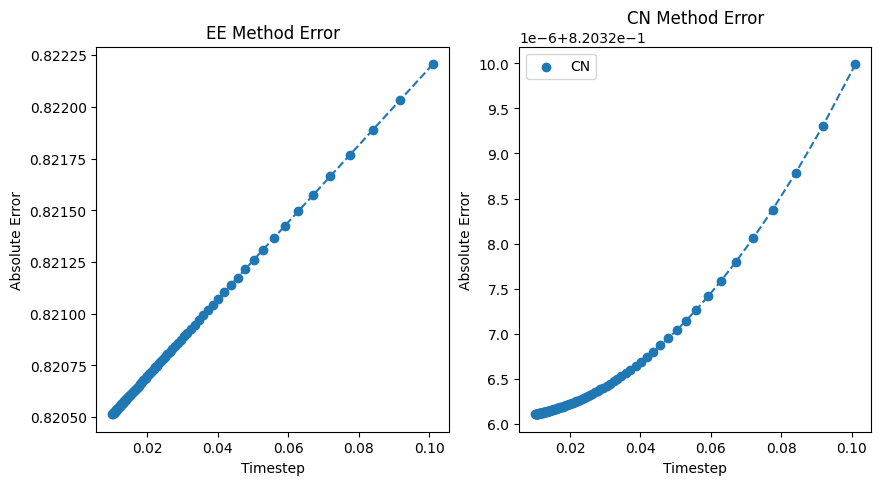

In [36]:
kappa = 0.001

dtinit = 0.01
dtfinal = 1
dtinc = 0.0001

loc = int(np.floor(Nx/2))

numtimesteps = np.arange(100,1000,10)
dts = np.zeros(len(numtimesteps))
EE_error = np.zeros(len(numtimesteps))
CN_error = np.zeros(len(numtimesteps))

for i, N in enumerate(numtimesteps):
  timearray = np.linspace(t_start,t_end,N)
  dts[i] = timearray[1]-timearray[0]
  EE_error[i] = np.abs(set_ics(x,kappa,t_end)[loc] - EE(x,timearray,kappa)[loc,-1])
  CN_error[i] = np.abs(set_ics(x,kappa,t_end)[loc] - CN(x,timearray,kappa)[loc,-1])

pEE, VEE = np.polyfit(dts, EE_error, 1, cov=True)
pCN, VCN = np.polyfit(dts, CN_error, 2, cov=True)

print(pEE)
ax, fig = plt.subplots(1,2, figsize=(10,5))
ax1 = plt.subplot(1,2,1)
ax1.scatter(dts, EE_error, label='EE')
ax1.plot(dts, pEE[0]*dts + pEE[1], linestyle='dashed')
ax1.set_xlabel('Timestep')
ax1.set_ylabel('Absolute Error')
ax1.set_title('EE Method Error')

ax2 = plt.subplot(1,2,2)
ax2.scatter(dts, CN_error, label='CN')
ax2.plot(dts, pCN[0]*dts*dts + pCN[1]*dt + pCN[2], linestyle='dashed')
ax2.set_xlabel('Timestep')
ax2.set_ylabel('Absolute Error')
ax2.set_title('CN Method Error')
plt.legend()
plt.show()




We see there is a clear linear correlation between the absolute error and timestep in the EE method, and a quadratic correlation for the CN method.

Finally, select a given error tolerance and explore whether explicit Euler or Crank-Nicoslon is more efficient (faster) at generating solutions with error less than your error tolerance. Discuss your conclusion and add supporting figures if necessary.

INSERT DISCUSSION OF ERROR HERE (~1 paragraph).  OPTIONALLY ADD PLOTS BY INSERTING A CODE BLOCK BELOW.

### 2.3 Boundary conditions for Crank-Nicolson scheme
<a id='section2pt3'></a>

The application of the boundary conditions for the Crank-Nicolson method isn't quite right in the script above (but the boundary conditions aren't very important in this example). Account for the boundary conditions by modifying the coefficient matrix. This should ensure that the boundary conditions are applied to the implicit and explicit terms involved in the Crank-Nicolson update. Plot your results below and verify that the boundary conditions are satisfied.  How would you handle fixed value (Dirichlet) and fixed gradient (Neumann) boundary conditions?

For fixed value (Dirichlet), we would approach this by enforcing a set of boundaries at each loop of the update within the EE and CN functions. This would look like setting c[0,k] = c_left and c[-1,k] = c_right instead of the current setting, which is just the next value along.

For fixed gradients (Von Neumann), it is a little trickier. The derivatives are encoded in M, so we must change some of its entries.